# KMNIST Pytorch Classification

import packages

In [ ]:
# import the necessary packages
from torch.nn import Module # Pytorch class to implement architecture
from torch.nn import Conv2d # Convolution layer implementation of pytorch
from torch.nn import Linear # Fully connected layer
from torch.nn import MaxPool2d # Reduce the dimension
from torch.nn import ReLU # Activation Function
from torch.nn import LogSoftmax # For returning the softmax classifier prediction
from torch.optim import Adam # Optimizer
from torch.utils.data import DataLoader # Pytorch data loading utility
from torchvision.transforms import ToTensor # preprocessing function that converts input data into a PyTorch tensor
from torchvision.datasets import KMNIST # The dataset
from sklearn.metrics import classification_report # For displaying a detailed classification report
from torch.utils.data import random_split # train/test split
from torch import flatten # flatten the output of a multi-dimensional volume
from torch import nn # Neural network
import matplotlib.pyplot as plt # Visulization
import numpy as np # Numerical Python
import torch # Pytorch
import time  # To check the training time

# **Creating model**



In [ ]:
class CustomModel(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(CustomModel, self).__init__()

		# initialize our first set of CONV => RELU => POOL layers. 
		# Our first CONV layer learns a total of 20 filters, each of which are 5×5. 
		# A ReLU activation function is then applied, followed by a 2×2 max-pooling layer with a 2×2 stride to reduce the spatial dimensions of our input image.
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()  # Non-linear activation function
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize our first and only set of fully connected layers. 
		# We define the number of inputs to the layer (800) along with our desired number of output nodes (500). 
		# A ReLu activation follows the FC layer.
		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()

		# initialize softmax classifier. The number of in_features is set to 500, which is the output dimensionality from the previous layer. 
		# We then apply LogSoftmax such that we can obtain predicted probabilities during evaluation.
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)

		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)

		# pass the output to our softmax classifier to get our output (Classifier)
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)

		# return the output predictions
		return output

# **Loading Data**


In [ ]:
# define training hyperparameters
INIT_LR = 1e-3 # initial learning rate
BATCH_SIZE = 64 # initial Batch Size
EPOCHS = 20 # initial Epoch

# define the train and val splits
TRAIN_SPLIT = 0.75 # 75% of training data
VAL_SPLIT = 1 - TRAIN_SPLIT # 25% of validation data

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [ ]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")
trainData = KMNIST(root="data", train=True, download=True,
	transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())

# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading the KMNIST dataset...


  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw

[INFO] generating the train/validation split...


In [ ]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

# **Training and Validation**

In [ ]:
# initialize the CustomModel
print("[INFO] initializing the CustomModel ...")
model = CustomModel(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

[INFO] initializing the CustomModel ...


In [ ]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0

	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))

		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)

		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))

			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)

			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/20
Train loss: 0.350423, Train accuracy: 0.8908
Val loss: 0.135900, Val accuracy: 0.9577

[INFO] EPOCH: 2/20
Train loss: 0.096421, Train accuracy: 0.9702
Val loss: 0.087137, Val accuracy: 0.9737

[INFO] EPOCH: 3/20
Train loss: 0.054830, Train accuracy: 0.9826
Val loss: 0.079415, Val accuracy: 0.9777

[INFO] EPOCH: 4/20
Train loss: 0.036605, Train accuracy: 0.9886
Val loss: 0.084674, Val accuracy: 0.9753

[INFO] EPOCH: 5/20
Train loss: 0.025451, Train accuracy: 0.9918
Val loss: 0.065389, Val accuracy: 0.9825

[INFO] EPOCH: 6/20
Train loss: 0.018804, Train accuracy: 0.9936
Val loss: 0.078943, Val accuracy: 0.9803

[INFO] EPOCH: 7/20
Train loss: 0.012959, Train accuracy: 0.9954
Val loss: 0.077443, Val accuracy: 0.9816

[INFO] EPOCH: 8/20
Train loss: 0.012463, Train accuracy: 0.9958
Val loss: 0.072058, Val accuracy: 0.9821

[INFO] EPOCH: 9/20
Train loss: 0.010169, Train accuracy: 0.9968
Val loss: 0.073116, Val accuracy: 0.9852

[INFO] EPOCH: 1

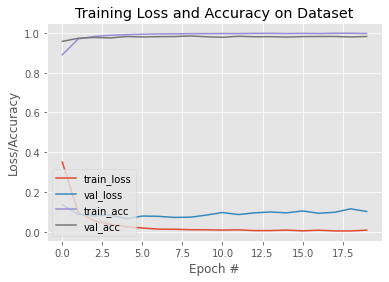

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

The plot shows our training history plot is smooth, demonstrating there is little/no overfitting happening.

Model achieves 99 % accuracy on the train set and 98% accuracy on the validation set. We can now work on the test set

# **Final test accuracy**

In [ ]:
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")

# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []

	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)

		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] evaluating network...
              precision    recall  f1-score   support

           o       0.96      0.96      0.96      1000
          ki       0.96      0.93      0.95      1000
          su       0.92      0.92      0.92      1000
         tsu       0.95      0.98      0.96      1000
          na       0.94      0.94      0.94      1000
          ha       0.96      0.95      0.96      1000
          ma       0.96      0.96      0.96      1000
          ya       0.97      0.95      0.96      1000
          re       0.94      0.97      0.96      1000
          wo       0.96      0.97      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



95% accuracy achieved on test set, a relativley high level of accuracy considering the difficulty of Hiragana characters.

In [ ]:
# serialize the model to disk
torch.save(model, "model.pth")

**implementing model prediction**

In [ ]:
# set the numpy seed for better reproducibility
import numpy as np
np.random.seed(42)
# import the necessary packages
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
import argparse
import imutils
import torch
import cv2

In [ ]:
# set the device we will be using to test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the KMNIST dataset and randomly grab 10 data points
print("[INFO] loading the KMNIST test dataset...")
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,))
testData = Subset(testData, idxs)
# initialize the test data loader
testDataLoader = DataLoader(testData, batch_size=1)
# load the model and set it to evaluation mode
model = torch.load('/content/model.pth')
print(testDataLoader)
model.eval()

[INFO] loading the KMNIST test dataset...


CustomModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [ ]:
from google.colab.patches import cv2_imshow
with torch.no_grad():
  for (image, label) in testDataLoader:
    # grab the original image and ground truth label
    origImage = image.numpy().squeeze(axis=(0, 1))
    gtLabel = testData.dataset.classes[label.numpy()[0]]
    # send the input to the device and make predictions on it
    image = image.to(device)
    pred = model(image)
    # find the class label index with the largest corresponding
		# probability
    idx = pred.argmax(axis=1).cpu().numpy()[0]
    predLabel = testData.dataset.classes[idx]
    result = True if gtLabel == predLabel else False
    print("original lavel: ", gtLabel , " Predicted level: ", predLabel, "Result: ", result)

original lavel:  ki  Predicted level:  ki Result:  True
original lavel:  ki  Predicted level:  ki Result:  True
original lavel:  ki  Predicted level:  ki Result:  True
original lavel:  ha  Predicted level:  ha Result:  True
original lavel:  tsu  Predicted level:  tsu Result:  True
original lavel:  ya  Predicted level:  ya Result:  True
original lavel:  tsu  Predicted level:  tsu Result:  True
original lavel:  na  Predicted level:  na Result:  True
original lavel:  ki  Predicted level:  ki Result:  True
original lavel:  tsu  Predicted level:  tsu Result:  True
